In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
complaints  = pd.read_csv('../final/complaints.csv')
complaints.columns
# complaints: time series? spatial info?

/Users/lorenzomasoero/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['complaint_no', 'beat', 'location_code', 'street_no', 'street_name',
       'apt_no', 'city', 'incident_datetime', 'complaint_date', 'closed_date'],
      dtype='object')

In [25]:
year_range = min(pd.to_datetime(complaints['complaint_date'].values).year), max(pd.to_datetime(complaints['complaint_date'].values).year)
length = 1+year_range[1]-year_range[0]
events_per_year = np.bincount(pd.to_datetime(complaints['complaint_date'].values).year)[-length:]
events_per_month = np.bincount(pd.to_datetime(complaints['complaint_date'].values).month)[1:]
events_per_day = np.bincount(pd.to_datetime(complaints['complaint_date'].values).weekday)
hours = pd.to_datetime(complaints['complaint_date'].values).hour
hours = np.nan_to_num(hours, nan=24)
events_per_hour = np.bincount(hours.astype(int))

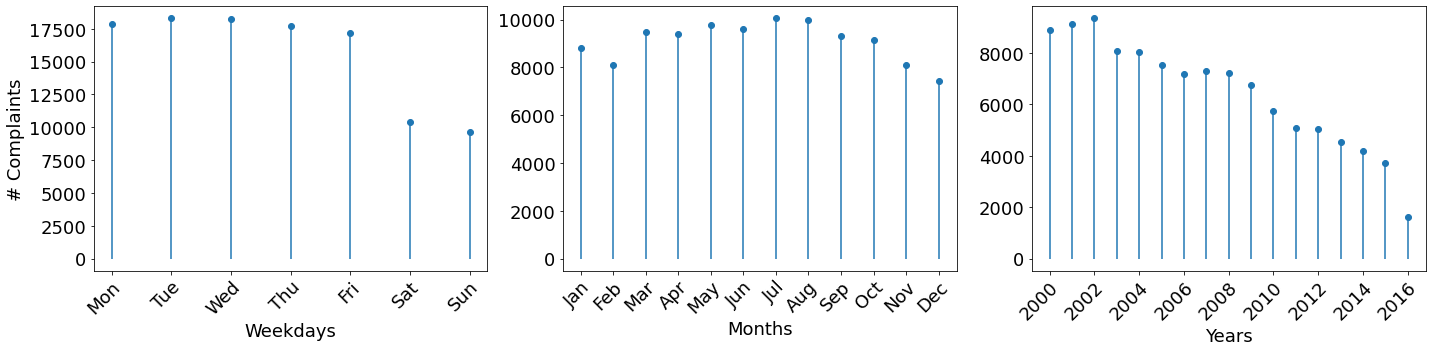

In [35]:


plt.figure(figsize = (20,5))

ax=plt.subplot(131)

plt.scatter(np.arange(len(events_per_day)), events_per_day)
plt.vlines(x = np.arange(len(events_per_day)), ymin = np.zeros(len(events_per_day)), ymax = events_per_day)
dayticks = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xticks(np.arange(len(events_per_day)), dayticks, fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('# Complaints', fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.xlabel('Weekdays', fontsize = 18)

ax=plt.subplot(132)

plt.scatter(np.arange(len(events_per_month)), events_per_month)
plt.vlines(x = np.arange(len(events_per_month)), ymin = np.zeros(len(events_per_month)), ymax = events_per_month)
monthticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(len(events_per_month)), monthticks, fontsize = 18)
plt.yticks(fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.xlabel('Months', fontsize = 18)

ax = plt.subplot(133)
plt.scatter(np.arange(year_range[0], year_range[1]+1, dtype = int), events_per_year)
plt.vlines(x = np.arange(year_range[0], year_range[1]+1, dtype = int), ymin = np.zeros(len(events_per_year)), ymax = events_per_year)
plt.xlabel('Years', fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize = 18)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right", rotation_mode="anchor") 
plt.tight_layout()
plt.savefig('../doc/figs/complaints_times.pdf', dpi=1000, bbox_inches = 'tight')
plt.savefig('../doc/figs/complaints_times.png', dpi=100, bbox_inches = 'tight')
plt.show()